# Mask Detection

## Setup

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
import numpy as np

import tensorflow as tf

## 1. Data

In [3]:
data_dir = "Facemaskdetection"

In [4]:
len(os.listdir("Facemaskdetection/train/With_mask"))

4086

In [5]:
len(os.listdir("Facemaskdetection/train/Without_mask"))

4032

## 2. Preprocessing

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
class_names = ["Mask", "No_Mask"]

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory("Facemaskdetection/train",
                                                      batch_size=32,
                                                      image_size=(img_height, img_width),
                                                      )

print(train_ds.class_names)

Found 8118 files belonging to 2 classes.
['With_mask', 'Without_mask']


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory("Facemaskdetection/val",
                                                      batch_size=32,
                                                      image_size=(img_height, img_width),
                                                      )
print(val_ds.class_names)

Found 1822 files belonging to 2 classes.
['With_mask', 'Without_mask']


## 3. Data Visualization

In [10]:
from matplotlib import pyplot as plt

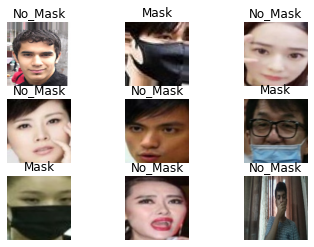

In [11]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 4. Model

In [16]:
from tensorflow.keras import layers

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.8),
    layers.RandomZoom(0.8),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1), 
  ]
)

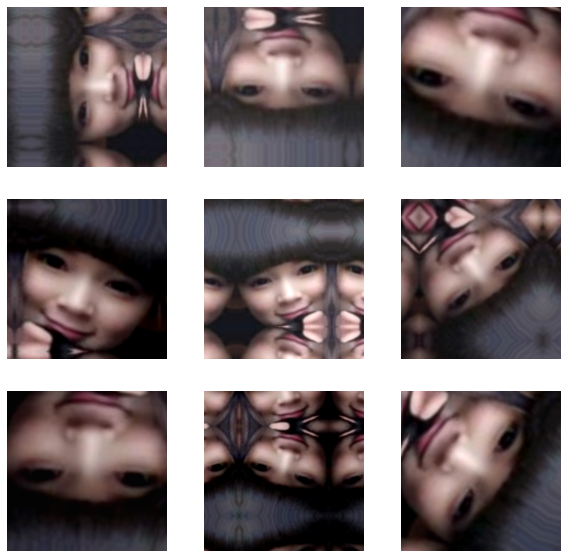

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
num_classes = 2

In [20]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
254/254 [==============================] - 143s 477ms/step - loss: 0.4472 - accuracy: 0.7960 - val_loss: 0.3638 - val_accuracy: 0.8584
Epoch 2/20
254/254 [==============================] - 105s 413ms/step - loss: 0.3774 - accuracy: 0.8390 - val_loss: 0.2960 - val_accuracy: 0.8919
Epoch 3/20
254/254 [==============================] - 105s 413ms/step - loss: 0.3536 - accuracy: 0.8498 - val_loss: 0.3084 - val_accuracy: 0.8776
Epoch 4/20
254/254 [==============================] - 106s 418ms/step - loss: 0.3438 - accuracy: 0.8556 - val_loss: 0.2620 - val_accuracy: 0.9012
Epoch 5/20
254/254 [==============================] - 106s 418ms/step - loss: 0.3302 - accuracy: 0.8597 - val_loss: 0.3061 - val_accuracy: 0.8639
Epoch 6/20
254/254 [==============================] - 105s 411ms/step - loss: 0.3162 - accuracy: 0.8709 - val_loss: 0.2503 - val_accuracy: 0.9001
Epoch 7/20
254/254 [==============================] - 108s 424ms/step - loss: 0.2948 - accuracy: 0.8805 - val_loss: 0.2411 -

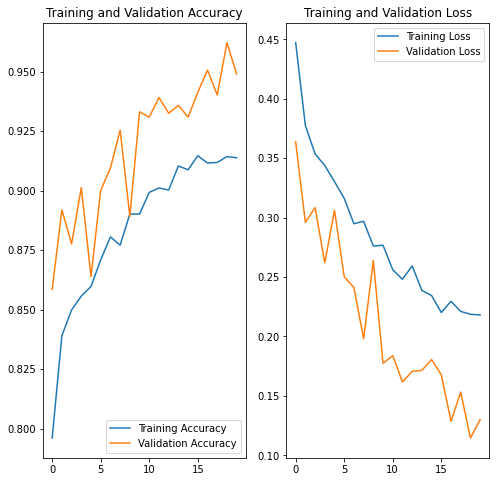

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [24]:
import matplotlib.image as mpimg

In [66]:
test_img_with_mask = "Facemaskdetection/test/Without_mask/augmented_357_2199611.png"

1/1 [==============================] - 0s 14ms/step
[[-1.7286388  1.8205304]]
tf.Tensor([0.02794514 0.97205484], shape=(2,), dtype=float32)
<class 'numpy.ndarray'>
[1]


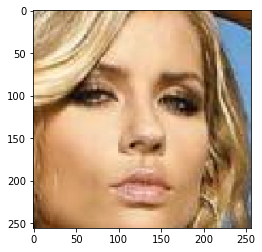

This image most likely belongs to No_Mask with a 97.21 percent confidence.


In [67]:
img = tf.keras.utils.load_img(
    test_img_with_mask, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(score)

# ['With_mask', 'Without_mask']
classes = predictions.argmax(axis=-1)
print(type(classes))
print(classes)

img = mpimg.imread(test_img_with_mask)
imgplot = plt.imshow(img)
plt.show()
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [29]:
model.save("FaceDetectionModel.h5")

In [38]:
def bulk_predict_image(folder):
    
    """
    Predicts Image with in bulk
    """
    
    num_list = []
    
    for file in os.listdir(folder):
        
        img = tf.keras.utils.load_img(
        folder + file, target_size=(img_height, img_width))
        
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        
        predictions = model.predict(img_array, verbose=0)
        score = tf.nn.softmax(predictions[0])
    
        classes = predictions.argmax(axis=-1)
        num_list.append(int(classes))
        
    if folder == "Facemaskdetection/test/With_mask/":
        print("Folder is", "Facemaskdetection/test/With_mask/")
        
    if folder == "Facemaskdetection/test/Without_mask/":
        print("Folder is", "Facemaskdetection/test/Without_mask/")
        
    return num_list

In [39]:
def visualize_results(num_list):
    
    # Total
    Total = len(num_list)
    print("The number of images is", Total)
    
    # Total 0 (Mask)
    without_mask = sum(num_list)
    with_mask = Total - without_mask
    
    # Total with mask
    print(with_mask, "is predicted with_mask")
    # Percentage of with_mask with total
    print(with_mask/ Total, "is the percentage with mask")
    
    chart = [with_mask, Total - with_mask]
    labels = ["With Mask", "Total"]
    plt.pie(chart)
    plt.show()

Folder is Facemaskdetection/test/With_mask/
The number of images is 849
739 is predicted with_mask
0.8704358068315665 is the percentage with mask


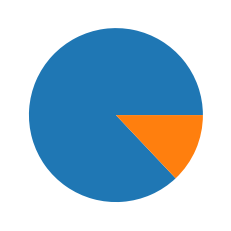

In [40]:
visualize_results(bulk_predict_image("Facemaskdetection/test/With_mask/"))

Folder is Facemaskdetection/test/Without_mask/
The number of images is 960
50 is predicted with_mask
0.052083333333333336 is the percentage with mask


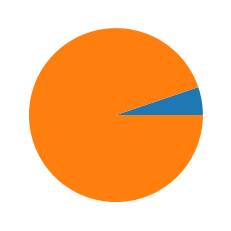

In [41]:
visualize_results(bulk_predict_image("Facemaskdetection/test/Without_mask/"))